# **1. Import Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

# **2. Upload Datasets For Stock Data And News Headlines**

In [ ]:
stock_price = pd.read_csv('HPPL.csv')
stock_headlines = pd.read_csv('raw_news (1).csv')

# **3. Data Cleaning**

In [ ]:
stock_price.head()

,published_date,open,high,low,close,per_change,traded_quantity,traded_amount,status,sentiment_score
0,2017-09-17,391.0,400.0,386.0,389.0,NaN,6660.0,2589340.0,0,0.44696
1,2017-09-18,389.0,399.0,377.0,392.0,0.77,9581.0,3714173.0,0,0.17710
2,2017-09-20,392.0,393.0,385.0,386.0,-1.53,5430.0,2107120.0,0,0.29280
3,2017-09-24,386.0,395.0,376.0,395.0,2.33,1960.0,751850.0,0,0.29240
4,2017-09-25,395.0,395.0,382.0,386.0,-2.28,4750.0,1839610.0,0,0.26478


In [ ]:
stock_price.tail()

,published_date,open,high,low,close,per_change,traded_quantity,traded_amount,status,sentiment_score
1668,2025-01-01,405.0,415.0,390.0,399.0,0.00,90722.0,35745755.5,-1,0.227900
1669,2025-01-02,391.1,403.9,391.1,401.9,0.73,47977.0,19159569.7,1,0.268100
1670,2025-01-05,395.0,408.0,395.0,405.5,0.90,49087.0,19838197.9,1,0.149670
1671,2025-01-06,402.0,417.0,402.0,415.0,2.34,77741.0,32109205.2,1,0.199525
1672,2025-01-07,415.0,421.1,411.0,416.7,0.41,102978.0,42679167.4,1,0.146100


In [ ]:
stock_headlines.head()

,published_date,Title
0,2011-03-25,Sunrise Bank Ltd has published a notice regard...
1,2011-03-25,Share Sansar Services
2,2011-03-25,Share Sansar Services
3,2011-03-25,NRB tightens criteria of FIs upgrading
4,2011-03-25,NRB declares Gorkha Development Bank


In [ ]:
stock_headlines.tail()

,published_date,Title
41211,2025-01-08,"Muktinath Bikas Bank Launches Exciting ""Annive..."
41212,2025-01-08,Proton E.Mas7 Series Ready to Transform Nepal’...
41213,2025-01-08,"Thulo Khola Hydropower Holds AGM, Approves IPO..."
41214,2025-01-08,Jagdulla Hydropower Denounces Allegations of M...
41215,2025-01-08,IPO Issue of Guardian Micro Life Insurance Clo...


In [ ]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(1673, 41216)

In [ ]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(published_date     False
 open               False
 high               False
 low                False
 close              False
 per_change          True
 traded_quantity    False
 traded_amount      False
 status             False
 sentiment_score    False
 dtype: bool,
 published_date    False
 Title             False
 dtype: bool)

# **3.1. Numerical Stock Data**

In [ ]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['published_date'] = pd.to_datetime(stock_price['published_date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['published_date', 'close', 'open', 'high', 'low', 'traded_quantity'])

# setting column 'Date' as the index column
stock_price.set_index('published_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,close,open,high,low,traded_quantity
published_date,,,,,
2017-09-17,389.0,391.0,400.0,386.0,6660.0
2017-09-18,392.0,389.0,399.0,377.0,9581.0
2017-09-20,386.0,392.0,393.0,385.0,5430.0
2017-09-24,395.0,386.0,395.0,376.0,1960.0
2017-09-25,386.0,395.0,395.0,382.0,4750.0
...,...,...,...,...,...
2025-01-01,399.0,405.0,415.0,390.0,90722.0
2025-01-02,401.9,391.1,403.9,391.1,47977.0
2025-01-05,405.5,395.0,408.0,395.0,49087.0


In [ ]:
stock_headlines

,published_date,Title
0,2011-03-25,Sunrise Bank Ltd has published a notice regard...
1,2011-03-25,Share Sansar Services
2,2011-03-25,Share Sansar Services
3,2011-03-25,NRB tightens criteria of FIs upgrading
4,2011-03-25,NRB declares Gorkha Development Bank
...,...,...
41211,2025-01-08,"Muktinath Bikas Bank Launches Exciting ""Annive..."
41212,2025-01-08,Proton E.Mas7 Series Ready to Transform Nepal’...
41213,2025-01-08,"Thulo Khola Hydropower Holds AGM, Approves IPO..."
41214,2025-01-08,Jagdulla Hydropower Denounces Allegations of M...


# **3.2. Textual News Headlines Data**

In [ ]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
#stock_headlines['published_date'] = stock_headlines['published_date'].astype(str)
#stock_headlines['published_date'] = stock_headlines['published_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
#stock_headlines['published_date'] = pd.to_datetime(stock_headlines['published_date'], format='%Y%m%d', errors='coerce').dt.normalize()
stock_headlines['published_date'] = pd.to_datetime(stock_headlines['published_date'], errors='coerce').dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['published_date', 'Title'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['published_date'])['Title'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('published_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,Title
published_date,
2011-03-25,Sunrise Bank Ltd has published a notice regard...
2011-03-26,Prime Commercial Bank Ltd. have alloted its ri...
2011-03-27,Western Development Bank has published a notic...
2011-03-28,Reliable Finance Limited has published a notic...
2011-03-29,"Seal on TIFA deal by mid-Apri,Nepse plunges to..."
...,...
2025-01-03,NEPSE Concludes Week With 1.69% Loss and Turno...
2025-01-05,NEPSE Surges By 5.32 Points with Rs. 4.86 Arba...
2025-01-06,NEPSE Index Surges By Significant 49.12 Points...


# **4. Combine Stock Data**

In [ ]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,close,open,high,low,traded_quantity,Title
published_date,,,,,,
2017-09-17,389.0,391.0,400.0,386.0,6660.0,Nepal Grameen FPO collects Rs 2.74 arba from 2...
2017-09-18,392.0,389.0,399.0,377.0,9581.0,“Nepal Investors Forum will advocate for marke...
2017-09-20,386.0,392.0,393.0,385.0,5430.0,NEPSE dips 3.89 points while posting a turnove...
2017-09-24,395.0,386.0,395.0,376.0,1960.0,Mutual Funds-- NAV dwindle in Bhadra; NAV of L...
2017-09-25,386.0,395.0,395.0,382.0,4750.0,Citizens Bank concludes 11th AGM; 16.85% divid...
...,...,...,...,...,...,...
2025-01-01,399.0,405.0,415.0,390.0,90722.0,NEPSE Risen by Minimal 0.19% Today While Turno...
2025-01-02,401.9,391.1,403.9,391.1,47977.0,Government Blacklists 12 Contractor Companies ...
2025-01-05,405.5,395.0,408.0,395.0,49087.0,NEPSE Surges By 5.32 Points with Rs. 4.86 Arba...


In [ ]:
#alternate way is to use merge funtion and inner join operation
pd.merge(stock_price, stock_headlines, left_index=True, right_index=True, how='inner')

,close,open,high,low,traded_quantity,Title
published_date,,,,,,
2017-09-17,389.0,391.0,400.0,386.0,6660.0,Nepal Grameen FPO collects Rs 2.74 arba from 2...
2017-09-18,392.0,389.0,399.0,377.0,9581.0,“Nepal Investors Forum will advocate for marke...
2017-09-20,386.0,392.0,393.0,385.0,5430.0,NEPSE dips 3.89 points while posting a turnove...
2017-09-24,395.0,386.0,395.0,376.0,1960.0,Mutual Funds-- NAV dwindle in Bhadra; NAV of L...
2017-09-25,386.0,395.0,395.0,382.0,4750.0,Citizens Bank concludes 11th AGM; 16.85% divid...
...,...,...,...,...,...,...
2025-01-01,399.0,405.0,415.0,390.0,90722.0,NEPSE Risen by Minimal 0.19% Today While Turno...
2025-01-02,401.9,391.1,403.9,391.1,47977.0,Government Blacklists 12 Contractor Companies ...
2025-01-05,405.5,395.0,408.0,395.0,49087.0,NEPSE Surges By 5.32 Points with Rs. 4.86 Arba...


# **5. Sentiment Analysis**

In [ ]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,close,open,high,low,traded_quantity,Title,compound,negative,neutral,positive
published_date,,,,,,,,,,
2017-09-17,389.0,391.0,400.0,386.0,6660.0,Nepal Grameen FPO collects Rs 2.74 arba from 2...,,,,
2017-09-18,392.0,389.0,399.0,377.0,9581.0,“Nepal Investors Forum will advocate for marke...,,,,
2017-09-20,386.0,392.0,393.0,385.0,5430.0,NEPSE dips 3.89 points while posting a turnove...,,,,
2017-09-24,395.0,386.0,395.0,376.0,1960.0,Mutual Funds-- NAV dwindle in Bhadra; NAV of L...,,,,
2017-09-25,386.0,395.0,395.0,382.0,4750.0,Citizens Bank concludes 11th AGM; 16.85% divid...,,,,


In [ ]:
 import nltk
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['Title'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['Title'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['Title'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['Title'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,close,open,high,low,traded_quantity,Title,compound,negative,neutral,positive
published_date,,,,,,,,,,
2017-09-17,389.0,391.0,400.0,386.0,6660.0,Nepal Grameen FPO collects Rs 2.74 arba from 2...,0.9849,0.000,0.799,0.201
2017-09-18,392.0,389.0,399.0,377.0,9581.0,“Nepal Investors Forum will advocate for marke...,0.7964,0.016,0.893,0.092
2017-09-20,386.0,392.0,393.0,385.0,5430.0,NEPSE dips 3.89 points while posting a turnove...,0.9702,0.000,0.787,0.213
2017-09-24,395.0,386.0,395.0,376.0,1960.0,Mutual Funds-- NAV dwindle in Bhadra; NAV of L...,0.9153,0.030,0.830,0.140
2017-09-25,386.0,395.0,395.0,382.0,4750.0,Citizens Bank concludes 11th AGM; 16.85% divid...,0.8957,0.030,0.829,0.140


In [ ]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['Title'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['close', 'compound', 'negative', 'neutral', 'positive', 'open', 'high', 'low', 'traded_quantity']]

# set the index name
stock_data.index.name = 'Date'

# displaying the final stock_data
stock_data.head()

,close,compound,negative,neutral,positive,open,high,low,traded_quantity
Date,,,,,,,,,
2017-09-17,389.0,0.9849,0.000,0.799,0.201,391.0,400.0,386.0,6660.0
2017-09-18,392.0,0.7964,0.016,0.893,0.092,389.0,399.0,377.0,9581.0
2017-09-20,386.0,0.9702,0.000,0.787,0.213,392.0,393.0,385.0,5430.0
2017-09-24,395.0,0.9153,0.030,0.830,0.140,386.0,395.0,376.0,1960.0
2017-09-25,386.0,0.8957,0.030,0.829,0.140,395.0,395.0,382.0,4750.0


In [ ]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

# **6. Exploratory Data Analysis**

In [ ]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(1671, 9)

In [ ]:
# checking for null values
stock_data.isna().any()

,0
close,False
compound,False
negative,False
neutral,False
positive,False
open,False
high,False
low,False
traded_quantity,False


In [ ]:
# displaying stock_data statistics
stock_data.describe(include='all')

,close,compound,negative,neutral,positive,open,high,low,traded_quantity
count,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000
mean,294.836505,0.826737,0.028306,0.839239,0.132471,294.676601,302.328127,287.164273,26251.353082
std,109.944120,0.304234,0.023907,0.047384,0.046797,110.601368,114.224737,105.951121,48099.833283
min,129.000000,-0.921300,0.000000,0.660000,0.009000,127.000000,130.000000,120.000000,10.000000
25%,206.500000,0.849050,0.012000,0.809000,0.101000,206.000000,211.250000,202.000000,1785.000000
50%,282.000000,0.934800,0.024000,0.840000,0.130000,282.000000,289.000000,275.300000,8275.000000
75%,370.500000,0.967150,0.041000,0.872500,0.163000,371.000000,378.000000,364.500000,27262.000000
max,726.000000,0.995200,0.137000,0.980000,0.302000,735.000000,749.100000,691.000000,434939.000000


In [ ]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1671 entries, 2017-09-17 to 2025-01-07
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   close            1671 non-null   float64
 1   compound         1671 non-null   float64
 2   negative         1671 non-null   float64
 3   neutral          1671 non-null   float64
 4   positive         1671 non-null   float64
 5   open             1671 non-null   float64
 6   high             1671 non-null   float64
 7   low              1671 non-null   float64
 8   traded_quantity  1671 non-null   float64
dtypes: float64(9)
memory usage: 130.5 KB


Text(0, 0.5, 'Close Price ($)')

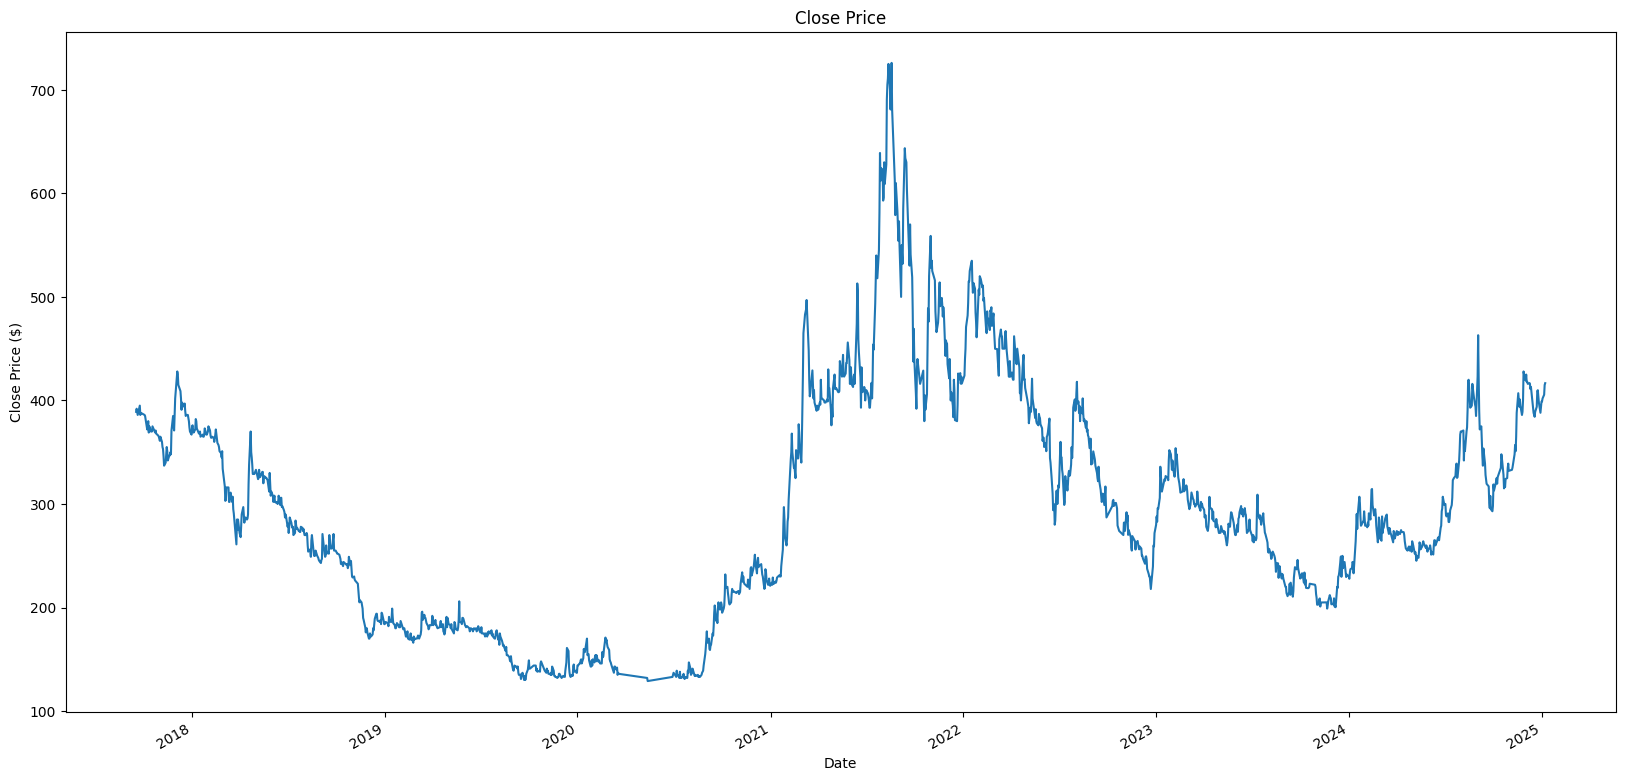

In [ ]:
# setting figure size
plt.figure(figsize=(20,10))

# plotting close price
stock_data['close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [ ]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,close,compound,negative,neutral,positive,open,high,low,traded_quantity
Date,,,,,,,,,
2017-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,388.857143,0.929200,0.013000,0.812571,0.174429,389.571429,395.428571,381.285714,5355.857143
2017-10-04,388.285714,0.907300,0.016714,0.816857,0.166429,388.857143,394.428571,381.000000,4844.428571
2017-10-08,385.428571,0.921800,0.016429,0.812571,0.170857,388.285714,392.571429,380.285714,4846.714286


<Axes: xlabel='Date'>

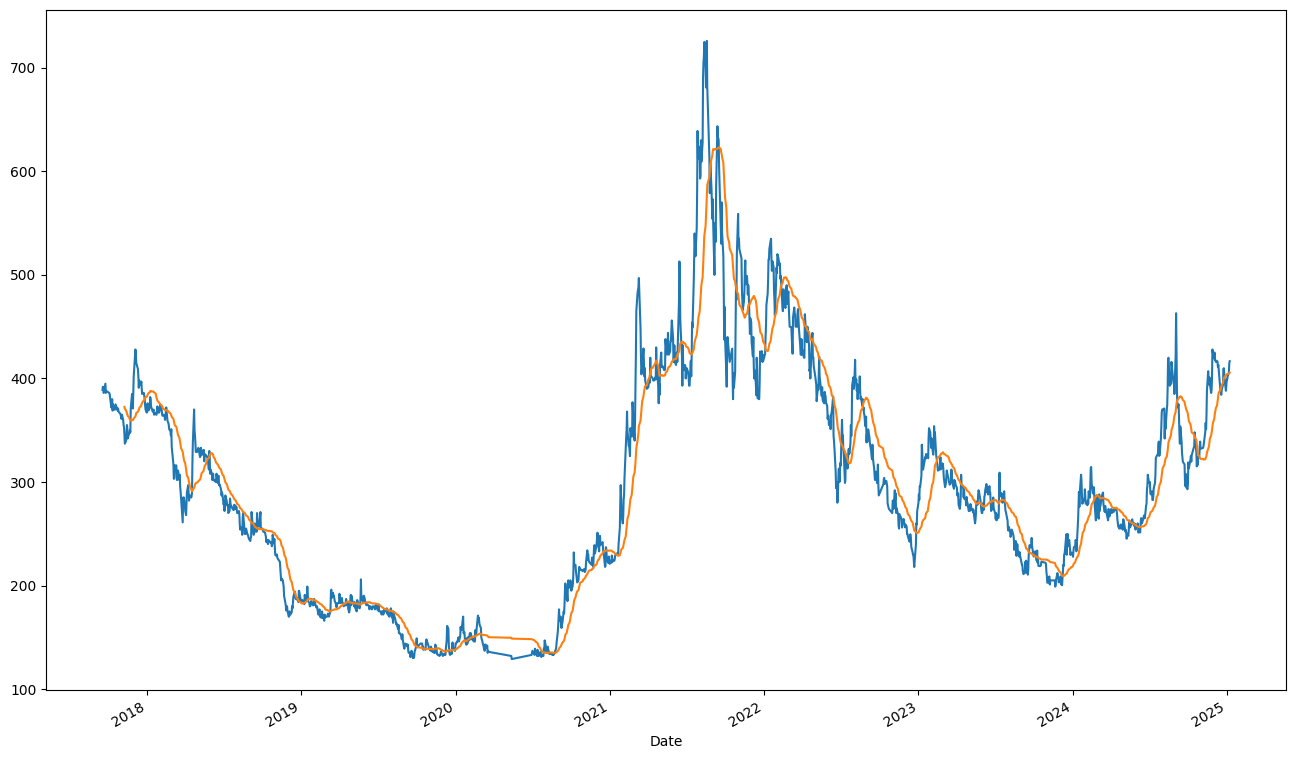

In [ ]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['close'].plot()
stock_data.rolling(window=30).mean()['close'].plot()

# **7. Data Preparation**

In [ ]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1336
Number of records in Test Data: 335


In [ ]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


,close
Date,
2017-09-18,392.0
2017-09-20,386.0
2017-09-24,395.0
2017-09-25,386.0
2017-09-26,388.0
...,...
2025-01-01,399.0
2025-01-02,401.9
2025-01-05,405.5


In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1)

# shifting next day compound
compound_shifted = compound.shift(-1)

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2017-09-18,392.0,386.0,0.7964,0.9702,9581.0,389.0,399.0,377.0
2017-09-20,386.0,395.0,0.9702,0.9153,5430.0,392.0,393.0,385.0
2017-09-24,395.0,386.0,0.9153,0.8957,1960.0,386.0,395.0,376.0
2017-09-25,386.0,388.0,0.8957,0.9899,4750.0,395.0,395.0,382.0
2017-09-26,388.0,386.0,0.9899,0.9520,7880.0,386.0,393.0,379.0
2017-10-03,386.0,385.0,0.9520,0.8316,1230.0,388.0,393.0,384.0
2017-10-04,385.0,372.0,0.8316,0.8979,3080.0,386.0,393.0,384.0
2017-10-08,372.0,375.0,0.8979,0.9558,9597.0,385.0,386.0,372.0
2017-10-09,375.0,380.0,0.9558,0.9779,3430.0,372.0,376.0,370.0


# **7.1. Setting Target Variable And Feature Dataset**

In [ ]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

,close_price_shifted
Date,
2017-09-18,386.0
2017-09-20,395.0
2017-09-24,386.0
2017-09-25,388.0
2017-09-26,386.0
...,...
2024-12-31,399.0
2025-01-01,401.9
2025-01-02,405.5


In [ ]:
# setting the features dataset for prediction
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2017-09-18,392.0,0.7964,0.9702,9581.0,389.0,399.0,377.0
2017-09-20,386.0,0.9702,0.9153,5430.0,392.0,393.0,385.0
2017-09-24,395.0,0.9153,0.8957,1960.0,386.0,395.0,376.0
2017-09-25,386.0,0.8957,0.9899,4750.0,395.0,395.0,382.0
2017-09-26,388.0,0.9899,0.9520,7880.0,386.0,393.0,379.0
...,...,...,...,...,...,...,...
2024-12-31,399.0,0.2003,0.9360,84614.0,384.2,399.0,380.5
2025-01-01,399.0,0.9360,0.9136,90722.0,405.0,415.0,390.0
2025-01-02,401.9,0.9136,0.9153,47977.0,391.1,403.9,391.1


# **7.3. Scaling the Target Variable and the Feature Dataset**

Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used

In [ ]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.11892797,  0.79253848,  0.97391077, ..., -0.13815789,
         -0.13099661, -0.09982487],
        [-0.13902848,  0.97391077,  0.91661884, ..., -0.12828947,
         -0.15037958, -0.07180385],
        [-0.10887772,  0.91661884,  0.89616488, ..., -0.14802632,
         -0.14391859, -0.1033275 ],
        ...,
        [-0.08576214,  0.91484477,  0.91661884, ..., -0.13125   ,
         -0.11516718, -0.05043783],
        [-0.07370184,  0.91661884,  0.92465432, ..., -0.11842105,
         -0.10192215, -0.03677758],
        [-0.04187605,  0.92465432,  0.86798852, ..., -0.09539474,
         -0.07284768, -0.01225919]]),
 array([[-0.13902848],
        [-0.10887772],
        [-0.13902848],
        ...,
        [-0.07370184],
        [-0.04187605],
        [-0.0361809 ]]))

# **7.4. Dividing the dataset into Training and Test**

Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]
y_train = y[0 : train_end]
y_test = y[train_end+1 : len(y)]

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1336, 7) and y: (1336, 1)
Number of rows and columns in the Test set X: (332, 7) and y: (332, 1)


In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1336, 7, 1)
Shape of Test set X: (332, 7, 1)


# **9. Stock Data Modelling**

In [ ]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1104 - val_loss: 0.0214
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0268 - val_loss: 0.0080
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0038 - val_loss: 0.0015


# **9.1. Saving the Model to disk**

In [ ]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights('model.weights.h5') # Change the filename to include .weights.h5
print('Model is saved to the disk')

Model is saved to the disk


# **10. Model Predictions**

In [ ]:
# performing predictions
predictions = model.predict(X_test)

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Predictions:


array([[279.912  ],
       [278.82324],
       [280.25092],
       [272.60458],
       [262.80493]], dtype=float32)

# **11. Model Evaluation**

In [ ]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0014
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.7743e-04
Train Loss = 0.0023
Test Loss = 0.0018


In [ ]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 300.2459


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 300.2459


# **12. Plotting the Predictions against unseen data**

In [ ]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

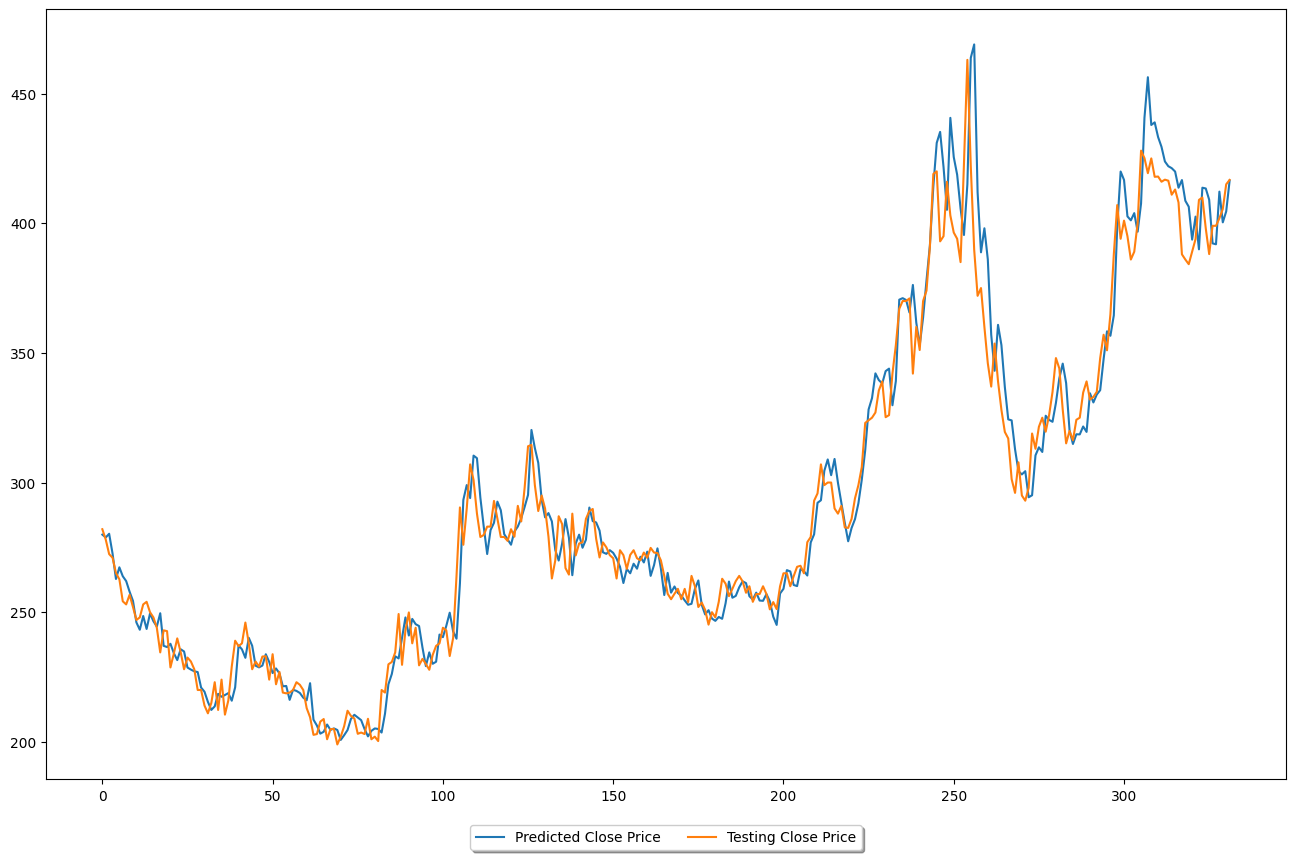

In [ ]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()